# Восстановление золота из руды

Необходимо создать прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

### Знакомство с данными.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [3]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [4]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [5]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [6]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Нам предоставлены данные в трех файлах: `gold_recovery_full` содержит все имеющиеся данные, остальные два файла `gold_recovery_test` и `gold_recovery_train` содержат уже разбитый исходный датасет на тренировочную и тестовую выборки. Данные индексируются датой и временем получения информации. Некоторые параметры в тестовой выборке могут быть недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Данные относительных характеристик предоставлены в процентах.

In [7]:
pd.set_option('display.max_columns', None)
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

### Рассчет эффективности обогащения.

Проверим, правильно ли рассчитана эффективность обогащения на этапе флотации в данных обучающей выборки. Сравним полученные нами результаты с имеющимися данными и рассчитаем MAE между ними.

In [8]:
# Формула для рассчета эффективности обогащения

def output_recovery(input_feed, output_concentrate, output_tail):
    return ((output_concentrate * (input_feed - output_tail)) / (input_feed * (output_concentrate - output_tail))) * 100

In [9]:
my_rougher_recovery = output_recovery(gold_recovery_train['rougher.input.feed_au'] / 100,
                                              gold_recovery_train['rougher.output.concentrate_au'] / 100,
                                              gold_recovery_train['rougher.output.tail_au'] / 100)

In [11]:
rougher_recovery_mae = mean_absolute_error(gold_recovery_train['rougher.output.recovery'], my_rougher_recovery)
f'{rougher_recovery_mae}'

'1.2770209105468604e-14'

Отклонение MAE между нашими рассчетами и имеющимися совсем незначительные, таким образом можно утверждать, что эффективность обогащения рассчитана верно.

### Признаки отсутствующие в тестовой выборке.

Некоторые признаки имеющиеся в полных данных отсутствуют в тестовой выборке. Рассмотрим данные параметры.

In [12]:
columns_not_in_test = [i for i in list(gold_recovery_full.columns) if i not in list(gold_recovery_test.columns)]
columns_not_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке ожидаемо отсутствует тип параметра `output` для любой стадии обработки. Для корректного обучения модели нам необходимо использовать только те признаки, которые имеются как в тестовой так и в обучающей выборке.

In [13]:
gold_recovery_train = gold_recovery_train.drop(columns_not_in_test, axis='columns')

### Предобработка данных.

Проверим данные на дубликаты.

In [14]:
gold_recovery_train.duplicated().sum()

0

В выборках присутствуют пропуски. Так как признаки представляют собой последовательные этапы, чтобы полностью не удалять объект можно заполнить пропуски значением из предыдущего или последующего этапа.

In [15]:
correct_order_of_columns = list(gold_recovery_train.columns[10:]) + list(gold_recovery_train.columns[1:10])
processing_stages = ['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']
for row in gold_recovery_train.index:
    for column in correct_order_of_columns:
        if np.isnan(gold_recovery_train.loc[row, column]):
            full_stage = column.split('.')
            processing_stages_nan = processing_stages.index(full_stage[0])
            if processing_stages_nan != 0:
                changed_stage = '.'.join([processing_stages[processing_stages_nan - 1]] + full_stage[1:])
                if changed_stage not in gold_recovery_train.columns and processing_stages_nan != 1:
                    changed_stage = '.'.join([processing_stages[processing_stages_nan - 2]] + full_stage[1:])
            else:
                changed_stage = '.'.join([processing_stages[processing_stages_nan + 1]] + full_stage[1:])
                if changed_stage not in gold_recovery_train.columns and processing_stages_nan != 3:
                    changed_stage = '.'.join([processing_stages[processing_stages_nan + 2]] + full_stage[1:])                    
            try:
                gold_recovery_train.loc[row, column] = gold_recovery_train.loc[row, changed_stage]
            except:
                None

In [16]:
gold_recovery_train = gold_recovery_train.dropna()
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12818 entries, 0 to 14148
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        12818 non-null  object 
 1   primary_cleaner.input.sulfate               12818 non-null  float64
 2   primary_cleaner.input.depressant            12818 non-null  float64
 3   primary_cleaner.input.feed_size             12818 non-null  float64
 4   primary_cleaner.input.xanthate              12818 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      12818 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    12818 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      12818 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    12818 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      12818 non-null  float64
 10  primary_cl

Таким образом, удалив объекты с пропусками нам удалось сохранить около 90% исходных данных (без заполнения пропусков у нас бы осталось около 80% данных).

_____

В данных присутствуют пропуски в некоторых столбцах тестовой выборки. Так как пропусков относительно немного, удаление объектов с пропусками в любом из столбцов не должно сильно отразиться на объеме данных.

In [17]:
gold_recovery_test = gold_recovery_test.dropna()

In [18]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5229 non-null   object 
 1   primary_cleaner.input.sulfate               5229 non-null   float64
 2   primary_cleaner.input.depressant            5229 non-null   float64
 3   primary_cleaner.input.feed_size             5229 non-null   float64
 4   primary_cleaner.input.xanthate              5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 10  primary_clea

На тестовой выборке удалось сохранить 99% данных.

## Анализ данных

### Концентрация металлов.

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

В среднем, концентрация золота(au) на этапе подачи исходного сырья = 8.27%,
концентрация серебра(ag) = 8.79%,    
концентрация свинца(pb) = 3.60%

В среднем, концентрация золота(au) на этапе подачи исходного сырья = 19.77%,
концентрация серебра(ag) = 11.99%,        
концентрация свинца(pb) = 7.61%

В среднем, концентрация золота(au) на этапе подачи исходного сырья = 32.12%,
концентрация серебра(ag) = 8.44%,        
концентрация свинца(pb) = 9.83%

В среднем, концентрация золота(au) на этапе подачи исходного сырья = 44.08%,
концентрация серебра(ag) = 5.17%,        
концентрация свинца(pb) = 9.98%



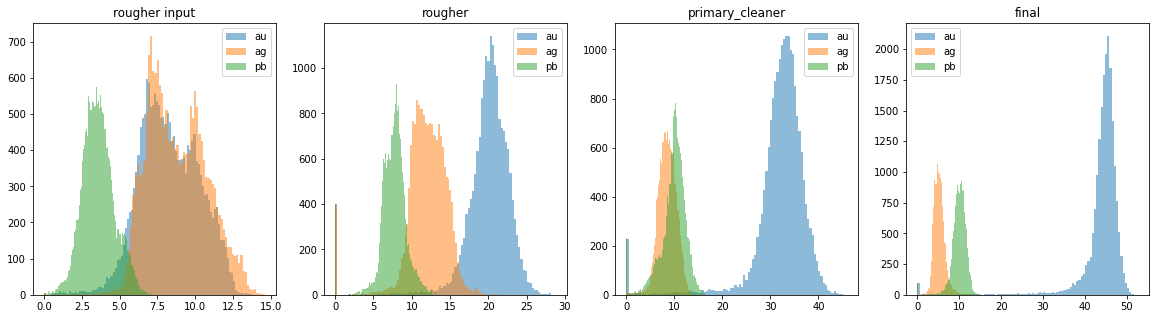

In [80]:
au = gold_recovery_full['rougher.input.feed_au']
ag = gold_recovery_full['rougher.input.feed_ag']
pb = gold_recovery_full['rougher.input.feed_pb']
print(f'В среднем, концентрация золота(au) на этапе подачи исходного сырья = {au.mean():.2f}%,\nконцентрация серебра(ag) = {ag.mean():.2f}%,\
    \nконцентрация свинца(pb) = {pb.mean():.2f}%', end='\n\n')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(20, 5)
ax1.hist(au, bins=100, label='au', alpha=0.5)
ax1.hist(ag, bins=100, label='ag', alpha=0.5)
ax1.hist(pb, bins=100, label='pb', alpha=0.5)
ax1.set_title('rougher input')
ax1.legend()

n = 0
axs = [ax2, ax3, ax4]
processing_stages = ['rougher', 'primary_cleaner', 'final']
for stage in processing_stages:
    ax = axs[n]
    au = gold_recovery_full[stage + '.output.concentrate_au']
    ag = gold_recovery_full[stage + '.output.concentrate_ag']
    pb = gold_recovery_full[stage + '.output.concentrate_pb']
    ax.hist(au, bins=100, label='au', alpha=0.5)
    ax.hist(ag, bins=100, label='ag', alpha=0.5)
    ax.hist(pb, bins=100, label='pb', alpha=0.5)
    ax.set_title(stage)
    ax.legend()
    n += 1  
    print(f'В среднем, концентрация золота(au) на этапе подачи исходного сырья = {au.mean():.2f}%,\nконцентрация серебра(ag) = {ag.mean():.2f}%,\
        \nконцентрация свинца(pb) = {pb.mean():.2f}%', end='\n\n')

Исходя из наблюдений можно заметить, что концентрация золота с каждым этапом увеличивается примерно на 12%, концентрация серебра падает примерно на 3%, а концентрация свинца увеличивается на 1-2%.

### Гранулы сырья на обучающей и тестовой выборках.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

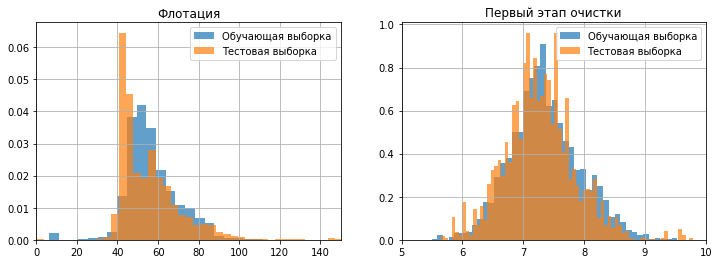

In [34]:
# Обучающая выборка

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(gold_recovery_train['rougher.input.feed_size'], bins=100, label='Обучающая выборка', alpha=0.7, density=True)
ax1.hist(gold_recovery_test['rougher.input.feed_size'], bins=100, label='Тестовая выборка', alpha=0.7, density=True)
ax1.set_title('Флотация')
ax1.legend()
ax1.grid()
ax1.set_xlim(0, 150)

ax2.hist(gold_recovery_train['primary_cleaner.input.feed_size'], bins=100, label='Обучающая выборка', alpha=0.7, density=True)
ax2.hist(gold_recovery_test['primary_cleaner.input.feed_size'], bins=100, label='Тестовая выборка', alpha=0.7, density=True)
ax2.legend()
ax2.set_title('Первый этап очистки')
ax2.grid()
ax2.set_xlim(5, 10)

fig.set_size_inches(12, 4)
plt.show()

На графиках видно, что распределения размеров гранул сырья не сильно различаются на тестовой и обучающей выборках.

### Суммарная концентрация веществ.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [21]:
processing_stages = ['rougher', 'primary_cleaner', 'final']

for stage in processing_stages:
    au = gold_recovery_full[stage + '.output.concentrate_au']
    ag = gold_recovery_full[stage + '.output.concentrate_ag']
    pb = gold_recovery_full[stage + '.output.concentrate_pb']
    sol = gold_recovery_full[stage + '.output.concentrate_sol']
    
    gold_recovery_full[stage + '.output.concentrate_sum'] = au + ag + pb + sol

Построим графики для получившихся значений суммарных концентраций. 

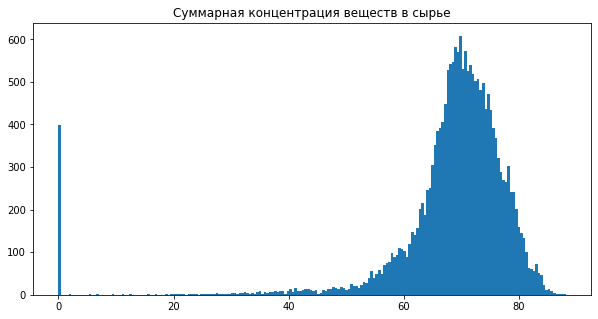

In [22]:
plt.figure(figsize=(10,5))
plt.hist(gold_recovery_full['rougher.output.concentrate_sum'], bins=200)
plt.title('Суммарная концентрация веществ в сырье')
plt.show()

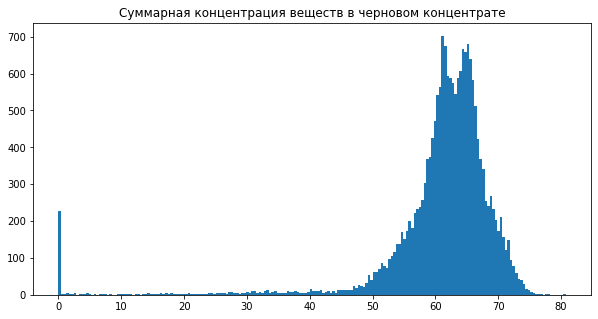

In [23]:
plt.figure(figsize=(10,5))
plt.hist(gold_recovery_full['primary_cleaner.output.concentrate_sum'], bins=200)
plt.title('Суммарная концентрация веществ в черновом концентрате')
plt.show()

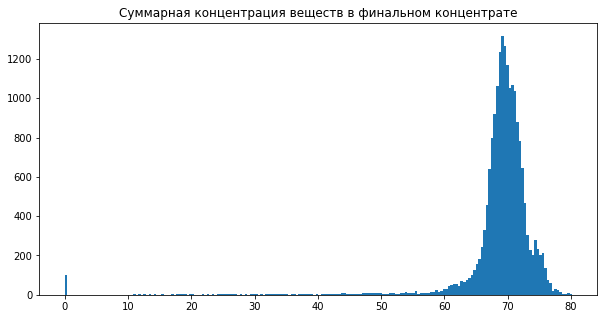

In [24]:
plt.figure(figsize=(10,5))
plt.hist(gold_recovery_full['final.output.concentrate_sum'], bins=200)
plt.title('Суммарная концентрация веществ в финальном концентрате')
plt.show()

На получившихся графиках мы можем наблюдать более-менее нормальное распределение со скосом влево и явные выбросы в околонулевом значении, количество которых снижается с каждым этапом обработки. Возможно выбросы появились в результате технического сбоя оборудования. 

Избавимся от выбросов и построим новые графики.

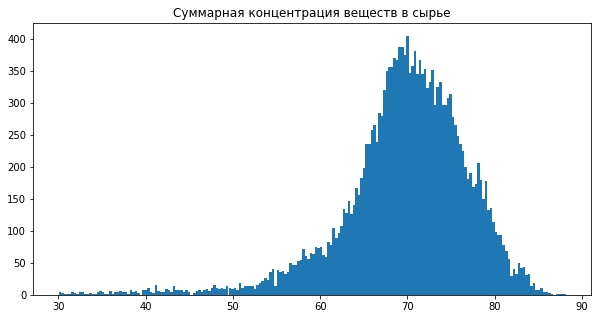

In [25]:
plt.figure(figsize=(10,5))
plt.hist(gold_recovery_full[gold_recovery_full['rougher.output.concentrate_sum'] > 30]['rougher.output.concentrate_sum'],
         bins=200)
plt.title('Суммарная концентрация веществ в сырье')
plt.show()

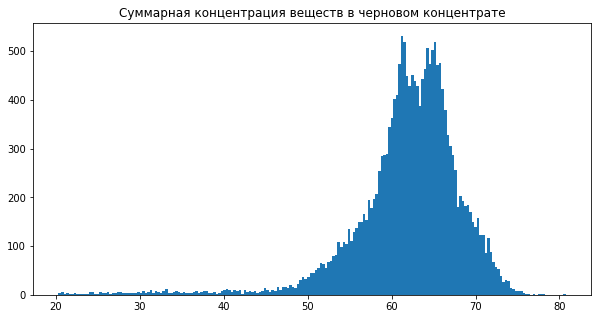

In [26]:
plt.figure(figsize=(10,5))
plt.hist(gold_recovery_full[gold_recovery_full['primary_cleaner.output.concentrate_sum'] > 20]['primary_cleaner.output.concentrate_sum'],
         bins=200)
plt.title('Суммарная концентрация веществ в черновом концентрате')
plt.show()

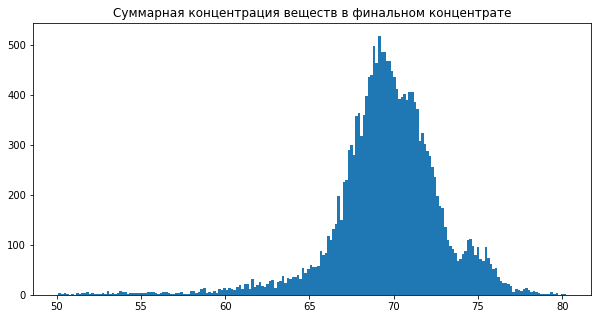

In [27]:
plt.figure(figsize=(10,5))
plt.hist(gold_recovery_full[gold_recovery_full['final.output.concentrate_sum'] > 50]['final.output.concentrate_sum']
         , bins=200)
plt.title('Суммарная концентрация веществ в финальном концентрате')
plt.show()

Сохраним в тех же таблицах `gold_recovery_train` и `gold_recovery_test` объекты, в которых отсутствуют выбросы, так как они могут негативно повлиять на качество нашей модели.

In [28]:
gold_recovery_full_without_outliers = gold_recovery_full[(gold_recovery_full['rougher.output.concentrate_sum'] > 30) &
                                                        (gold_recovery_full['primary_cleaner.output.concentrate_sum'] > 20) &
                                                        (gold_recovery_full['final.output.concentrate_sum'] > 50)]
gold_recovery_full_without_outliers_dates = gold_recovery_full_without_outliers['date']

In [29]:
gold_recovery_train = gold_recovery_train[gold_recovery_train['date'].isin(gold_recovery_full_without_outliers_dates)]
gold_recovery_test = gold_recovery_test[gold_recovery_test['date'].isin(gold_recovery_full_without_outliers_dates)]

## Модель

### Метрика sMAPE 

Напишем функцию для вычисления sMAPE - метрики, которой мы будем оценивать качество обученной модели. 

In [30]:
def smape(y_true, y_pred):
    return sum(abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2)) / len(y_true) * 100

scorer = make_scorer(smape)

### Построение модели.

Исходя из самого процесса обработки сырья можно предположить, что признаки коррелируют между собой, то есть обладают мультиколлиниарностью, что плохо сказывается прежде всего на качестве моделей линейной регрессии. С мультиколлинеарностью можно попробовать справиться при помощи удаления коррелирующих признаков, однако поскольку большинство признаков взаимосвязаны между собой, логичнее будет отказаться от модели линейной регрессии, и вместо нее воспользоваться моделью случайного леса.

Нам необходимо построить две модели, так как мы имеем два целевых признака `rougher.output.recovery` и `final.output.recovery`

In [31]:
gold_recovery_train_without_date = gold_recovery_train.loc[:, 'primary_cleaner.input.sulfate':]
gold_recovery_test_without_date = gold_recovery_test.loc[:, 'primary_cleaner.input.sulfate':]

rougher_train_target = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_train['date'])]['rougher.output.recovery']
rougher_test_target = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])]['rougher.output.recovery']

final_train_target = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_train['date'])]['final.output.recovery']
final_test_target = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])]['final.output.recovery']

In [32]:
# Подберем оптимальные гипперпараметры для модели рассчитывающей эффективность обогащения чернового концентрата. 

best_smae = 100
best_n_est = 0
best_depth = 0

for n_est in tqdm([5, 10, 20, 50]):
    for depth in tqdm(range(1, 10)):
        model = RandomForestRegressor(max_depth=depth, n_estimators=n_est, random_state=123)
        smae = cross_val_score(model, gold_recovery_train_without_date, rougher_train_target, cv=5, scoring=scorer).mean()
        if smae < best_smae:
            best_smae = smae
            best_n_est = n_est
            best_depth = depth
        
print(f'Лучший показатель sMAE для модели рассчитывающей эффективность обогащения чернового концентрата составляет {best_smae:.2f}, \
достигается при глубине дерева {best_depth} и количестве деревьев оценщиков равном {best_n_est}.')   

# Лучший показатель sMAE для модели рассчитывающей эффективность обогащения чернового концентрата 
# составляет 5.88, достигается при глубине дерева 6 и количестве деревьев оценщиков равном 20.

 25%|██▌       | 1/4 [00:34<01:42, 34.23s/it]


KeyboardInterrupt: 

In [ ]:
# Подберем оптимальные гипперпараметры для модели рассчитывающей эффективность обогащения финального концентрата. 

best_smae = 100
best_n_est = 0
best_depth = 0

for n_est in tqdm([5, 10, 20, 50]):
    for depth in tqdm(range(1, 10)):
        model = RandomForestRegressor(max_depth=depth, n_estimators=n_est, random_state=123)
        smae = cross_val_score(model, gold_recovery_train_without_date, final_train_target, cv=5, scoring=scorer).mean()
        if smae < best_smae:
            best_smae = smae
            best_n_est = n_est
            best_depth = depth
        
print(f'Лучший показатель sMAE для модели рассчитывающей эффективность обогащения финального концентрата составляет {best_smae:.2f}, \
достигается при глубине дерева {best_depth} и количестве деревьев оценщиков равном {best_n_est}.')   

# Лучший показатель sMAE для модели рассчитывающей эффективность обогащения финального концентрата 
# составляет 8.14, достигается при глубине дерева 6 и количестве деревьев оценщиков равном 20.

Таким образом, мы выяснили, что оптимальные гипперпараметры для обеих моделей совпадают. 

In [ ]:
# Определяем sMAPE для модели рассчитывающей эффективность обогащения чернового концентрата на тестовой выборке.

model = RandomForestRegressor(max_depth=6, n_estimators=20, random_state=123)

model.fit(gold_recovery_train_without_date, rougher_train_target)
predicted_values = model.predict(gold_recovery_test_without_date)
smape_rougher = smape(rougher_test_target, predicted_values)

print(f'Показатель sMAPE для модели рассчитывающей эффективность обогащения чернового концентрата составляет {smape_rougher:.2%}')

In [ ]:
# Определяем sMAPE для модели рассчитывающей эффективность обогащения финального концентрата на тестовой выборке.

model = RandomForestRegressor(max_depth=6, n_estimators=20, random_state=123)

model.fit(gold_recovery_train_without_date, final_train_target)
predicted_values = model.predict(gold_recovery_test_without_date)
smape_final = smape(final_test_target, predicted_values)

print(f'Показатель sMAPE для модели рассчитывающей эффективность обогащения финального концентрата составляет {smape_final:.2%}')

На основе полученных значений, вычислим итоговое значение метрики.

In [ ]:
smape = (smape_rougher * 0.25) + (0.75 * smape_final)
smape

В конечном итоге нам удалось построить модель с наименьшим показателем sMAPE равным 7.1%.

## Вывод

Задачей нашего исследования являлось создание прототипа модели машинного обучения для компании «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна уметь предсказывать коэффициент восстановления золота из золотосодержащей руды пользуясь данными с параметрами добычи и очистки.

Нам были предоставлены данные в трех файлах: `gold_recovery_full` содержит все имеющиеся данные, остальные два файла `gold_recovery_test` и `gold_recovery_train` содержат уже разбитый исходный датасет на тренировочную и тестовую выборки. Данные были проиндексированы датой и временем получения информации. Некоторые параметры в тестовой выборке были недоступны, потому что замеряются или рассчитываются значительно позже. Данные относительных характеристик были предоставлены в процентах.

В ходе подготовки данных нами было проверено, правильно ли рассчитана эффективность обогащения на этапе флотации в данных обучающей выборки. Отклонение MAE между нашими рассчетами и имеющимися оказались совсем незначительные, таким образом можно утверждать, что эффективность обогащения была рассчитана верно.

Некоторые признаки имеющиеся в полных данных отсутствали в тестовой выборке. Так, в тестовой выборке ожидаемо отсутствали параметры output для любой стадии обработки. Для корректного обучения модели мы оставили только те признаки, которые имелись как в тестовой, так и в обучающей выборке.

В выборках отсутствовали дубликаты, однако присутствали пропуски. Так как признаки представляют собой последовательные этапы, чтобы полностью не удалять объект было решено заполнить пропуски значением из предыдущего или последующего этапа. Таким образом, удалив объекты с пропусками нам удалось сохранить около 90% исходных данных в обучающей выборке и 99% данных на тестовой выборке.

В ходе анализа нами было рассмотрено как менялась концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Исходя из наблюдений было замечено, что концентрация золота с каждым этапом увеличивается примерно на 12%, концентрация серебра падает примерно на 3%, а концентрация свинца увеличивается на 1-2%.

Затем мы сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. Если бы распределения сильно отличались друг от друга, оценка модели была бы неправильной. На графиках было продемонстрировано, что распределения размеров гранул сырья не сильно различаются на тестовой и обучающей выборках.

Было проведено исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах и построены соответствующие графики распределения. На получившихся графиках мы могли наблюдать более-менее нормальное распределение со скосом влево и явные выбросы в околонулевом значении, количество которых снижается с каждым этапом обработки. Возможно выбросы появились в результате технического сбоя оборудования. Было решено избавиться от выбросов, так как они могли негативно повлиять на качество нашей модели.

Исходя из самого процесса обработки сырья мы смогли предположить, что признаки коррелируют между собой, то есть обладают мультиколлиниарностью, что плохо сказывается прежде всего на качестве моделей линейной регрессии. С мультиколлинеарностью можно было попробовать справиться при помощи удаления коррелирующих признаков, однако поскольку большинство признаков взаимосвязаны между собой, логичнее будет отказаться от модели линейной регрессии, и вместо нее воспользоваться моделью случайного леса. Построив две модели для чернового и финального этапа обработки мы выяснили, что оптимальные гипперпараметры для обеих моделей совпадают. Показатель sMAPE для модели рассчитывающей эффективность обогащения чернового концентрата на тестовой выборке составил 4.18%, показатель sMAPE для модели рассчитывающей эффективность обогащения финального концентрата составил 8.07%. Итоговая метрика складывается из двух величин, и в конечном итоге нам удалось построить модель с наименьшим показателем иговой метрики sMAPE равным 7.1%.

